In [1]:
import tensorflow as tf
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
import string
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
from joblib import Parallel, delayed
from textblob import Word
from joblib import Parallel, delayed
import pyarrow.parquet as pq
import pyarrow as pa
import re
from nltk.stem import PorterStemmer,   WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

C:\Users\ARBAJ\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import pandas as pd
X=pd.read_csv(r"C:\Users\ARBAJ\Downloads\ICD Codes.csv")
X.head()

,ICDCode,Description
0,A000,"Cholera due to Vibrio cholerae 01, biovar c..."
1,A001,"Cholera due to Vibrio cholerae 01, biovar e..."
2,A009,"Cholera, unspecified"
3,A0100,"Typhoid fever, unspecified"
4,A0101,Typhoid meningitis


In [3]:
X.shape#row and column count of data

(73639, 2)

In [4]:
X[X.columns[0]].nunique() #unique numbers of ICD codes

73639

In [5]:
X[X.columns[1]].nunique() #number of Description (unique)

73639

In [6]:
X.tail()

,ICDCode,Description
73634,Z9981,Dependence on supplemental oxygen
73635,Z9989,Dependence on other enabling machines and de...
73636,U070,Vaping-related disorder
73637,U071,COVID-19
73638,U099,"Post COVID-19 condition, unspecified"


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73639 entries, 0 to 73638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ICDCode      73639 non-null  object
 1   Description  73639 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [8]:
X['symptoms count']=X['Description'].apply(lambda x:len(str(x).split(',')))
X

,ICDCode,Description,symptoms count
0,A000,"Cholera due to Vibrio cholerae 01, biovar c...",2
1,A001,"Cholera due to Vibrio cholerae 01, biovar e...",2
2,A009,"Cholera, unspecified",2
3,A0100,"Typhoid fever, unspecified",2
4,A0101,Typhoid meningitis,1
...,...,...,...
73634,Z9981,Dependence on supplemental oxygen,1
73635,Z9989,Dependence on other enabling machines and de...,1
73636,U070,Vaping-related disorder,1
73637,U071,COVID-19,1


C:\Users\ARBAJ\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


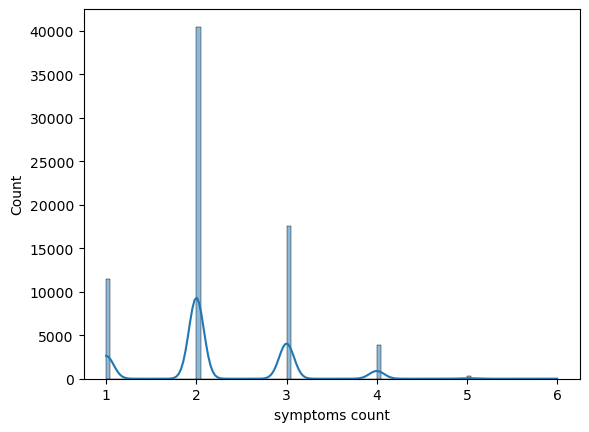

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(X['symptoms count'],kde=True)
plt.show()

In [123]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ARBAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ARBAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ARBAJ\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [11]:
stop_words = set(stopwords.words('english'))

def process_review(review):#Function to process each review: tokenization, stopwords removal, and lemmatization
    sentences = sent_tokenize(review)#Tokenize, remove stopwords, and lemmatize the review text.
    processed_words = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        processed_sentence = [
            str(Word(word).lemmatize()) for word in words if word.isalpha() and word.lower() not in stop_words
        ]#Remove stopwords and non-alphabetic tokens, then lemmatize
    
        processed_words.extend(processed_sentence)#Join the processed words back into a sentence
    
    return ' '.join(processed_words)

In [12]:
def process_batch(start, end, reviews,column_name):#Function to process a batch of reviews in parallel
    batch_data = []
    for i in range(start, end):
        review = reviews.loc[i, column_name]
        processed_review = process_review(review)
        batch_data.append(processed_review)
    return batch_data

In [13]:
def save_to_parquet(data, filename):# Function to save processed data to a Parquet file
    table = pa.Table.from_pandas(pd.DataFrame(data, columns=['Processed Tokens']))
    pq.write_table(table, filename)

In [14]:
batch_size = 100000
num_batches = 8

# Process the reviews in parallel and store the results
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(process_batch)(batch_num * batch_size, min((batch_num + 1) * batch_size, len(X)), X,'Description')
    for batch_num in range(num_batches))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.9s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    3.0s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    3.0s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    3.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   14.1s finished


In [15]:
processed_reviews = [item for sublist in results for item in sublist]# Flatten
save_to_parquet(processed_reviews, 'ICDcodes.parquet')# Save the processed reviews to Parquet

print("All batches processed and saved to 'ICDcodes.parquet'.")

All batches processed and saved to 'ICDcodes.parquet'.


In [99]:
import pandas as pd
Data = pd.read_parquet('ICDcodes.parquet')# Load the Parquet file into a DataFrame
Data.head()

,Processed Tokens
0,Cholera due Vibrio cholerae biovar cholerae
1,Cholera due Vibrio cholerae biovar eltor
2,Cholera unspecified
3,Typhoid fever unspecified
4,Typhoid meningitis


In [100]:
X.head()

,ICDCode,Description,symptoms count
0,A000,"Cholera due to Vibrio cholerae 01, biovar c...",2
1,A001,"Cholera due to Vibrio cholerae 01, biovar e...",2
2,A009,"Cholera, unspecified",2
3,A0100,"Typhoid fever, unspecified",2
4,A0101,Typhoid meningitis,1


In [101]:
Z=pd.concat([X,Data],axis=1)
Z.head()#concatinating ICD codes and Processed tokens

,ICDCode,Description,symptoms count,Processed Tokens
0,A000,"Cholera due to Vibrio cholerae 01, biovar c...",2,Cholera due Vibrio cholerae biovar cholerae
1,A001,"Cholera due to Vibrio cholerae 01, biovar e...",2,Cholera due Vibrio cholerae biovar eltor
2,A009,"Cholera, unspecified",2,Cholera unspecified
3,A0100,"Typhoid fever, unspecified",2,Typhoid fever unspecified
4,A0101,Typhoid meningitis,1,Typhoid meningitis


In [102]:
Z.drop(columns=['symptoms count'],axis=1,inplace=True)

In [103]:
Z.head()

,ICDCode,Description,Processed Tokens
0,A000,"Cholera due to Vibrio cholerae 01, biovar c...",Cholera due Vibrio cholerae biovar cholerae
1,A001,"Cholera due to Vibrio cholerae 01, biovar e...",Cholera due Vibrio cholerae biovar eltor
2,A009,"Cholera, unspecified",Cholera unspecified
3,A0100,"Typhoid fever, unspecified",Typhoid fever unspecified
4,A0101,Typhoid meningitis,Typhoid meningitis


In [104]:
Z.shape

(73639, 3)

In [105]:
Z['Tokens']=Z['Processed Tokens'].apply(lambda x:str(x).split())
Z.head()

,ICDCode,Description,Processed Tokens,Tokens
0,A000,"Cholera due to Vibrio cholerae 01, biovar c...",Cholera due Vibrio cholerae biovar cholerae,"[Cholera, due, Vibrio, cholerae, biovar, chole..."
1,A001,"Cholera due to Vibrio cholerae 01, biovar e...",Cholera due Vibrio cholerae biovar eltor,"[Cholera, due, Vibrio, cholerae, biovar, eltor]"
2,A009,"Cholera, unspecified",Cholera unspecified,"[Cholera, unspecified]"
3,A0100,"Typhoid fever, unspecified",Typhoid fever unspecified,"[Typhoid, fever, unspecified]"
4,A0101,Typhoid meningitis,Typhoid meningitis,"[Typhoid, meningitis]"


In [117]:
import gensim
from gensim.models import Word2Vec

W2v=Word2Vec(sentences=Z['Tokens'],window=2,sg=0,vector_size=500,min_count=1,workers=-1)

In [118]:
W2v.save('ICDcodesW2V1.model')

In [108]:
def vectorizer(Token,W2v,vector_size=500):
    vector=[W2v.wv[i] for i in Token if i in W2v.wv ]
    if vector:
        return np.mean(vector,axis=0) 
    else:
        return np.zeros(vector_size) 

In [109]:
Z['Vectors']=Z['Tokens'].apply(lambda x:vectorizer(x,W2v,vector_size=500))
Z.head()

,ICDCode,Description,Processed Tokens,Tokens,Vectors
0,A000,"Cholera due to Vibrio cholerae 01, biovar c...",Cholera due Vibrio cholerae biovar cholerae,"[Cholera, due, Vibrio, cholerae, biovar, chole...","[-0.00020600182, 0.0005850599, 9.523879e-05, -..."
1,A001,"Cholera due to Vibrio cholerae 01, biovar e...",Cholera due Vibrio cholerae biovar eltor,"[Cholera, due, Vibrio, cholerae, biovar, eltor]","[0.00041014832, 0.00016616682, -0.00015956548,..."
2,A009,"Cholera, unspecified",Cholera unspecified,"[Cholera, unspecified]","[-0.00046163026, -0.00033942107, 0.000554119, ..."
3,A0100,"Typhoid fever, unspecified",Typhoid fever unspecified,"[Typhoid, fever, unspecified]","[-0.00052904314, 0.00095695123, 0.0002551322, ..."
4,A0101,Typhoid meningitis,Typhoid meningitis,"[Typhoid, meningitis]","[-0.001042555, 0.0014264965, 0.00048670542, 0...."


In [110]:
Z.to_csv('ICD_Codes_Tokens.csv')

In [111]:
TR=pd.DataFrame(Z['Vectors'].tolist())
TR['Target']=Z['ICDCode']
TR.head()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,Target
0,-0.000206,0.000585,0.000095,-0.001241,0.000270,-0.000132,-0.000278,-0.000508,0.000640,0.000443,...,0.000731,-0.000713,-0.000024,0.001098,0.000228,0.000269,-0.000260,-0.000113,0.000975,A000
1,0.000410,0.000166,-0.000160,-0.001157,0.000077,0.000150,0.000124,-0.000369,0.000306,0.000625,...,0.000632,-0.000721,-0.000244,0.001014,-0.000087,0.000087,-0.000098,-0.000025,0.000800,A001
2,-0.000462,-0.000339,0.000554,0.000303,-0.000091,-0.000702,-0.000286,0.000461,0.000031,0.001511,...,0.000944,-0.000316,-0.000096,-0.000186,-0.001917,-0.000112,0.000525,-0.000389,0.001708,A009
3,-0.000529,0.000957,0.000255,0.000553,-0.000478,-0.000506,-0.000701,-0.000196,-0.000528,0.001073,...,0.000203,-0.000849,0.000313,0.000031,0.000315,-0.000606,0.000224,-0.000240,0.000812,A0100
4,-0.001043,0.001426,0.000487,0.000648,-0.000354,-0.000266,0.000046,-0.000064,0.000097,-0.000520,...,-0.000460,-0.000422,0.000749,-0.000011,0.001224,0.001423,-0.000282,-0.000233,0.000260,A0101


In [112]:
from sklearn.decomposition import PCA
PC=PCA(n_components=0.96)
Z1=PC.fit_transform(TR.iloc[:,:-1])
Z1=pd.DataFrame(Z1)
Z1['Codes']=TR['Target']
Z1

,0,1,2,3,4,5,6,7,8,9,...,402,403,404,405,406,407,408,409,410,Codes
0,-0.000621,-0.000788,0.000224,0.001449,-0.000622,0.000011,0.002327,-0.001890,0.000142,1.021177e-03,...,0.000506,0.000562,0.000462,-0.001137,0.000709,0.000095,0.000476,0.000048,0.000251,A000
1,-0.000256,-0.000965,-0.000246,0.001139,-0.000318,0.000024,0.002168,-0.002103,-0.000057,8.257757e-04,...,0.000519,0.000241,0.000560,-0.000586,0.000670,-0.000096,-0.000193,0.000287,0.000193,A001
2,-0.005050,0.010075,0.002228,0.000391,-0.000650,0.000819,-0.001124,-0.000850,-0.001685,-1.000555e-04,...,0.000556,-0.000127,0.001272,-0.000492,0.001402,-0.000216,-0.000144,0.000388,-0.000762,A009
3,-0.004369,0.007032,0.000874,0.000113,-0.000238,0.001557,0.000415,0.000678,-0.000527,-3.989267e-04,...,-0.000330,-0.000197,0.000461,-0.000679,-0.000024,-0.000217,0.000501,-0.000564,0.000342,A0100
4,-0.001852,-0.001151,-0.000383,0.000872,0.000583,0.001674,0.003007,0.000478,0.000078,4.689111e-04,...,-0.000117,0.000063,0.000641,-0.001157,-0.000214,-0.000213,0.000706,-0.000550,0.000475,A0101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73634,-0.000377,-0.001558,-0.000909,0.000267,0.000086,0.001142,0.001196,-0.000055,-0.000614,4.420925e-04,...,-0.000070,-0.001094,-0.000115,0.000856,-0.000188,-0.000195,-0.000530,-0.000119,-0.000595,Z9981
73635,-0.001355,-0.002073,0.000864,-0.000321,0.000742,0.000481,0.001822,0.000193,-0.000108,-6.087821e-07,...,0.000068,0.000155,0.000143,0.000149,0.000008,-0.000430,0.000205,0.000529,-0.000206,Z9989
73636,-0.001710,-0.000516,0.000126,0.002834,0.001183,0.000953,0.004941,-0.001557,0.000654,-4.703559e-03,...,-0.000043,0.000302,0.000047,0.000206,0.000007,0.000093,-0.000042,0.000173,0.000039,U070
73637,-0.001255,-0.001002,-0.000444,0.000646,0.000254,0.000403,0.001341,-0.000249,0.000112,1.666225e-04,...,-0.000007,0.000023,0.000032,-0.000020,-0.000063,-0.000030,0.000003,-0.000011,-0.000012,U071


In [113]:
PC.explained_variance_ratio_.sum()

0.9601098711556092

In [114]:
import joblib
joblib.dump(PC, 'PCA_model_ICD.pkl')

['PCA_model_ICD.pkl']

In [115]:
joblib.load('PCA_model_ICD.pkl')

PCA(n_components=0.96)

In [120]:
Z1['DESCRIBE']=Z['Description']
Z1

,0,1,2,3,4,5,6,7,8,9,...,403,404,405,406,407,408,409,410,Codes,DESCRIBE
0,-0.000621,-0.000788,0.000224,0.001449,-0.000622,0.000011,0.002327,-0.001890,0.000142,1.021177e-03,...,0.000562,0.000462,-0.001137,0.000709,0.000095,0.000476,0.000048,0.000251,A000,"Cholera due to Vibrio cholerae 01, biovar c..."
1,-0.000256,-0.000965,-0.000246,0.001139,-0.000318,0.000024,0.002168,-0.002103,-0.000057,8.257757e-04,...,0.000241,0.000560,-0.000586,0.000670,-0.000096,-0.000193,0.000287,0.000193,A001,"Cholera due to Vibrio cholerae 01, biovar e..."
2,-0.005050,0.010075,0.002228,0.000391,-0.000650,0.000819,-0.001124,-0.000850,-0.001685,-1.000555e-04,...,-0.000127,0.001272,-0.000492,0.001402,-0.000216,-0.000144,0.000388,-0.000762,A009,"Cholera, unspecified"
3,-0.004369,0.007032,0.000874,0.000113,-0.000238,0.001557,0.000415,0.000678,-0.000527,-3.989267e-04,...,-0.000197,0.000461,-0.000679,-0.000024,-0.000217,0.000501,-0.000564,0.000342,A0100,"Typhoid fever, unspecified"
4,-0.001852,-0.001151,-0.000383,0.000872,0.000583,0.001674,0.003007,0.000478,0.000078,4.689111e-04,...,0.000063,0.000641,-0.001157,-0.000214,-0.000213,0.000706,-0.000550,0.000475,A0101,Typhoid meningitis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73634,-0.000377,-0.001558,-0.000909,0.000267,0.000086,0.001142,0.001196,-0.000055,-0.000614,4.420925e-04,...,-0.001094,-0.000115,0.000856,-0.000188,-0.000195,-0.000530,-0.000119,-0.000595,Z9981,Dependence on supplemental oxygen
73635,-0.001355,-0.002073,0.000864,-0.000321,0.000742,0.000481,0.001822,0.000193,-0.000108,-6.087821e-07,...,0.000155,0.000143,0.000149,0.000008,-0.000430,0.000205,0.000529,-0.000206,Z9989,Dependence on other enabling machines and de...
73636,-0.001710,-0.000516,0.000126,0.002834,0.001183,0.000953,0.004941,-0.001557,0.000654,-4.703559e-03,...,0.000302,0.000047,0.000206,0.000007,0.000093,-0.000042,0.000173,0.000039,U070,Vaping-related disorder
73637,-0.001255,-0.001002,-0.000444,0.000646,0.000254,0.000403,0.001341,-0.000249,0.000112,1.666225e-04,...,0.000023,0.000032,-0.000020,-0.000063,-0.000030,0.000003,-0.000011,-0.000012,U071,COVID-19


In [121]:
Z1.to_csv('ICD_Codes_Vector_Representation.csv')

In [ ]:
import gensim
from gensim.models import Word2Vec
W2v = Word2Vec.load('ICDcodesW2V.model')# Load the trained Word2Vec model

In [48]:
def Test_process(symptoms):
    A=process_review(symptoms)
    A1=A.split()
    A2=vectorizer(A1,W2v,vector_size=500).tolist()
    A3=PC.transform([A2])
    return A3

In [60]:
test='Cholera'
Test1=Test_process(test)
Test1

array([[ 1.28454454e-04, -2.37229866e-03,  2.53398694e-04,
         2.07754728e-04, -1.32710965e-04,  2.39119536e-04,
         2.79073450e-03, -2.97938693e-03, -1.99172580e-03,
        -7.31307636e-04,  2.66508033e-03, -9.04946036e-04,
         1.55253299e-03,  1.19980908e-03,  4.21107576e-04,
         2.95056106e-03, -3.76730143e-04, -8.45620847e-04,
         7.63540804e-05, -1.28117081e-03,  3.67837728e-04,
         9.92934020e-04, -9.08149641e-04,  1.46820437e-03,
        -3.90629290e-04, -1.67517026e-03,  1.74900509e-03,
        -1.47762549e-03,  7.57998111e-04, -1.37276217e-03,
        -5.80845313e-04, -6.94964887e-04,  7.57165655e-05,
         1.12330022e-03, -2.03122643e-03,  1.84751463e-05,
        -9.56748286e-04,  7.67862424e-04, -1.69512834e-03,
         2.99413734e-04,  6.21484769e-04,  1.01560866e-03,
         3.79661338e-04,  5.55834377e-04, -1.38641600e-03,
         2.36651751e-04,  1.65633691e-03, -2.94500633e-04,
         1.16363936e-03, -3.87702129e-05,  1.06478329e-0

In [61]:
from sklearn.metrics.pairwise import cosine_similarity
simm=[]
for i in range(100):
    row=Z1.iloc[i,:-1]
    code=Z1.iloc[i,-1]
    Desc=Z.loc[i,'Description']
    Simillarity=cosine_similarity(Test1,[row])
    simm.append((Simillarity,code,Desc))
    

In [62]:
pd.DataFrame(simm).sort_values(by=0,ascending=False).head(2)

,0,1,2
2,[[0.6190379806050721]],A009,"Cholera, unspecified"
1,[[0.46965345292513927]],A001,"Cholera due to Vibrio cholerae 01, biovar e..."


In [52]:
stop_words = set(stopwords.words('english'))

def process_review(review):#Function to process each review: tokenization, stopwords removal, and lemmatization
    sentences = sent_tokenize(review)#Tokenize, remove stopwords, and lemmatize the review text.
    processed_words = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        processed_sentence = [
            str(Word(word).lemmatize()) for word in words if word.isalpha() and word.lower() not in stop_words
        ]#Remove stopwords and non-alphabetic tokens, then lemmatize
    
        processed_words.extend(processed_sentence)#Join the processed words back into a sentence
    
    return ' '.join(processed_words)

In [91]:
simm=[]
def test_input(inputs,W2v,PC):
    stop_words = set(stopwords.words('english'))

    def process_review(review):
        sentences = sent_tokenize(review)
        processed_words = []
        for sentence in sentences:
            words = word_tokenize(sentence)
            processed_sentence = [
                str(Word(word).lemmatize()) for word in words if word.isalpha() and word.lower() not in stop_words
            ]

            processed_words.extend(processed_sentence)

        return ' '.join(processed_words)

    A=process_review(inputs)
    A1=A.split()
    A2=vectorizer(A1,W2v,vector_size=500).tolist()
    A3=PC.transform([A2])
    simm=[]
    for i in range(100):
        row=Z1.iloc[i,:-1]
        code=Z1.iloc[i,-1]
        Desc=Z.loc[i,'Description']
        Simillarity=cosine_similarity(A3,[row])
        simm.append((Simillarity,code,Desc))
    Final=pd.DataFrame(simm).sort_values(by=0,ascending=False).head(5)
    Final.columns=['SIMILLARITY %', 'ICD CODES','SYMPTOMS']
    Final['SIMILLARITY %'] = Final['SIMILLARITY %'].apply(lambda x: np.around(x[0][0]*100),2)

    return Final

In [92]:
test_input('Typhoid fever, unspecified',W2v,PC)

C:\Users\ARBAJ\AppData\Local\Temp\ipykernel_9128\1127695097.py:16: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  Final['SIMILLARITY %'] = Final['SIMILLARITY %'].apply(lambda x: np.around(x[0][0]*100),2)


,SIMILLARITY %,ICD CODES,SYMPTOMS
3,100.0,A0100,"Typhoid fever, unspecified"
13,67.0,A014,"Paratyphoid fever, unspecified"
9,66.0,A0109,Typhoid fever with other complications
5,54.0,A0102,Typhoid fever with heart involvement
2,43.0,A009,"Cholera, unspecified"


In [65]:
Z1

,0,1,2,3,4,5,6,7,8,9,...,402,403,404,405,406,407,408,409,410,Codes
0,-0.000621,-0.000788,0.000224,0.001449,-0.000622,0.000011,0.002327,-0.001890,0.000142,1.021177e-03,...,0.000506,0.000562,0.000462,-0.001137,0.000709,0.000095,0.000476,0.000048,0.000251,A000
1,-0.000256,-0.000965,-0.000246,0.001139,-0.000318,0.000024,0.002168,-0.002103,-0.000057,8.257757e-04,...,0.000519,0.000241,0.000560,-0.000586,0.000670,-0.000096,-0.000193,0.000287,0.000193,A001
2,-0.005050,0.010075,0.002228,0.000391,-0.000650,0.000819,-0.001124,-0.000850,-0.001685,-1.000555e-04,...,0.000556,-0.000127,0.001272,-0.000492,0.001402,-0.000216,-0.000144,0.000388,-0.000762,A009
3,-0.004369,0.007032,0.000874,0.000113,-0.000238,0.001557,0.000415,0.000678,-0.000527,-3.989267e-04,...,-0.000330,-0.000197,0.000461,-0.000679,-0.000024,-0.000217,0.000501,-0.000564,0.000342,A0100
4,-0.001852,-0.001151,-0.000383,0.000872,0.000583,0.001674,0.003007,0.000478,0.000078,4.689111e-04,...,-0.000117,0.000063,0.000641,-0.001157,-0.000214,-0.000213,0.000706,-0.000550,0.000475,A0101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73634,-0.000377,-0.001558,-0.000909,0.000267,0.000086,0.001142,0.001196,-0.000055,-0.000614,4.420925e-04,...,-0.000070,-0.001094,-0.000115,0.000856,-0.000188,-0.000195,-0.000530,-0.000119,-0.000595,Z9981
73635,-0.001355,-0.002073,0.000864,-0.000321,0.000742,0.000481,0.001822,0.000193,-0.000108,-6.087821e-07,...,0.000068,0.000155,0.000143,0.000149,0.000008,-0.000430,0.000205,0.000529,-0.000206,Z9989
73636,-0.001710,-0.000516,0.000126,0.002834,0.001183,0.000953,0.004941,-0.001557,0.000654,-4.703559e-03,...,-0.000043,0.000302,0.000047,0.000206,0.000007,0.000093,-0.000042,0.000173,0.000039,U070
73637,-0.001255,-0.001002,-0.000444,0.000646,0.000254,0.000403,0.001341,-0.000249,0.000112,1.666225e-04,...,-0.000007,0.000023,0.000032,-0.000020,-0.000063,-0.000030,0.000003,-0.000011,-0.000012,U071
